<h1><center>Main Notebook - Decision Tree</center></h1>

# Imports & Setup

In [ ]:
%load_ext autoreload
%autoreload 2
from utils import *
import utils.transformers.transformers as tr
import utils.transformers.sk4pandas as s4p
import utils.transformers.knimp as knp

import os
import pickle
import urllib.request
import warnings

import git
from IPython.core.magic import register_cell_magic
from matplotlib.pyplot import figure
import mlflow
import pandas as pd
from sklearn import set_config
from sklearn.base import clone
from sklearn.compose import make_column_selector
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, loguniform
from sklearn.tree import DecisionTreeClassifier, plot_tree

warnings.filterwarnings('ignore')
set_config(display='text')

git_repo = git.Repo(os.getcwd())

@register_cell_magic
def run_and_save(line, cell):
    'Run and save python code block to a file'
    with open(line, 'wt') as fd:
        fd.write(cell)
    code = compile(cell, line, 'exec')
    exec(code, globals())

# Init Datasets

In [ ]:
raw_main_df = pd.read_csv('data/train.csv')
raw_sub_df = pd.read_csv('data/test.csv')
raw_train_df, raw_test_df = train_test_split(raw_main_df, test_size=100, random_state=42)

X_all, y_all = raw_main_df.drop('Survived', axis=1), raw_main_df['Survived']
X_train, y_train = raw_train_df.drop('Survived', axis=1), raw_train_df['Survived']
X_test, y_test = raw_test_df.drop('Survived', axis=1), raw_test_df['Survived']

raw_train_df.sample(5, random_state=42)

# Prepare Pipeline

In [ ]:
%%run_and_save blueprints/pipeline.py


clip_outliers = [(
    'Float',
    tr.ClipOutliers(std_band=3),
    make_column_selector(dtype_include=['float64'])
)]

fillna_constant = [(
    'Cabin',
    s4p.SimpleImputer(strategy='constant', fill_value='UNKNOWN'),
    ['Cabin']
),(
    'Age',
    s4p.SimpleImputer(strategy='constant', fill_value=-9999.),
    ['Age']
)]


steps_main = [
    ('Set working columns', tr.SetupFeatures(cols_ignore=['PassengerId', 'Name', 'Ticket']) ),
    ('Format Cabins', tr.Cabin() ),
    ('Standardize', s4p.StandardScaler(cols_select=['Age', 'Fare']) ),
    ('Clip Outliers', tr.ClipOutliers(cols_select=['Age', 'Fare'], std_band=3)),
    ('Replace NaNs With Constants', s4p.ColumnTransformer(fillna_constant, remainder='passthrough') ),
    ('Prepare coltypes for imputation', tr.AsTypes() ),
    ('Impute NaNs left with KNN', knp.KNImp(min_frequency=20) ),
    ('OneHot Encoding', s4p.OneHotEncoder(cols_select=['Cabin', 'Pclass', 'Sex', 'SibSp', 'Embarked', 'Parch']) ),
    ('Decision Tree', DecisionTreeClassifier())
]

pipe = Pipeline(steps_main)

# Grid Params

In [ ]:
%%run_and_save blueprints/grid_params.py

n_iter = 50

ml_params_distributions = {
    'Decision Tree__min_samples_leaf': loguniform(10, 100).rvs(n_iter).astype('int'),
}

rs = RandomizedSearchCV (
    pipe,
    param_distributions = ml_params_distributions,
    n_iter=n_iter,
    n_jobs=-1,
    refit=True,
    cv=CVSplitter(5, 80),
    return_train_score=True
)

# ML Flow Run

In [ ]:
mlflow.sklearn.autolog(max_tuning_runs=3)

with mlflow.start_run(run_name='Decision Tree - After New KNN Imp - rs min_samples_leaf') as run:
    mlflow.set_tags(get_lastcommit_infos(git_repo))
    mlflow.log_artifact('blueprints/pipeline.py', 'blueprints')
    mlflow.log_artifact('blueprints/grid_params.py', 'blueprints')
    rs.fit(X_all, y_all)

# Refit best model

In [ ]:
run_id = '734810f6d63d4b7ba0a0606ae5cdac8d'
#url_local_model = f'file:///Users/i538262/Desktop/Developments/PERSO/KAGGLE%20Titanic/mlruns/0/{run_id}/artifacts/model/model.pkl'
url_local_model = f'file:///Users/i538262/Desktop/Developments/PERSO/KAGGLE%20Titanic/mlruns/0/{run_id}/artifacts/best_estimator/model.pkl'

with urllib.request.urlopen(url_local_model) as model_file:
    best_model = pickle.load(model_file)
    
best_model_allfit = clone(best_model)
best_model_allfit.fit(X_all, y_all)

# Submit models predictions

In [ ]:
branch_name = get_lastcommit_infos(git_repo)['Branch']
submit(f'submissions/{branch_name}/{run_id}.csv', raw_sub_df.PassengerId, best_model_allfit.predict(raw_sub_df))

# Model insights

[Text(0.4642857142857143, 0.9444444444444444, 'Sex_female <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]'),
 Text(0.21428571428571427, 0.8333333333333334, 'Cabin_UNKNOWN <= 0.5\ngini = 0.306\nsamples = 577\nvalue = [468, 109]'),
 Text(0.14285714285714285, 0.7222222222222222, 'gini = 0.486\nsamples = 94\nvalue = [55, 39]'),
 Text(0.2857142857142857, 0.7222222222222222, 'Parch_0 <= 0.5\ngini = 0.248\nsamples = 483\nvalue = [413, 70]'),
 Text(0.21428571428571427, 0.6111111111111112, 'gini = 0.405\nsamples = 71\nvalue = [51, 20]'),
 Text(0.35714285714285715, 0.6111111111111112, 'Fare <= -0.188\ngini = 0.213\nsamples = 412\nvalue = [362, 50]'),
 Text(0.2857142857142857, 0.5, 'Age <= 0.193\ngini = 0.18\nsamples = 351\nvalue = [316, 35]'),
 Text(0.21428571428571427, 0.3888888888888889, 'Age <= -0.22\ngini = 0.197\nsamples = 271\nvalue = [241, 30]'),
 Text(0.14285714285714285, 0.2777777777777778, 'Age <= -1.254\ngini = 0.162\nsamples = 213\nvalue = [194, 19]'),
 Text(0.071428571428571

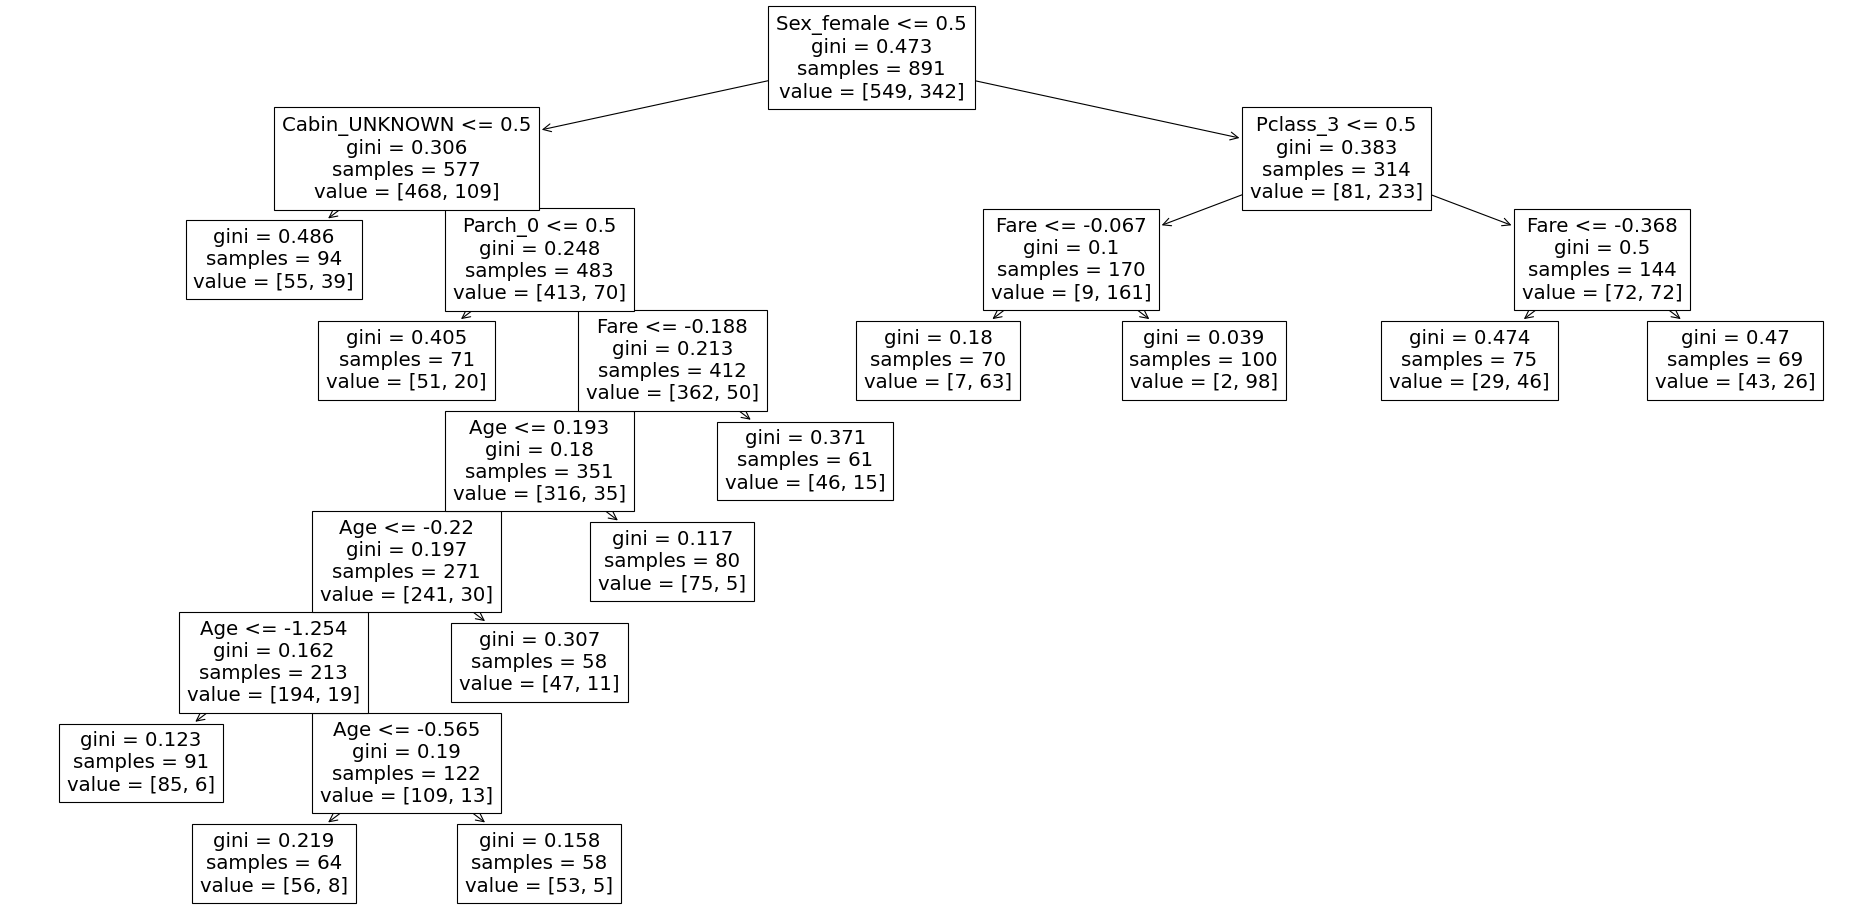

In [29]:
figure(figsize=(30, 15), dpi=80)

plot_tree(best_model_allfit[-1], feature_names=best_model_allfit[:-1].transform(X_all).columns)

# Code tests